In [ ]:
 #import dataset
 !git clone https://bitbucket.org/jadslim/german-traffic-signs.git

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [ ]:
#list the files 
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random

In [ ]:
np.random.seed(0)

In [ ]:
#unpickle pickeled files
with open('german-traffic-signs/train.p','rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p','rb')as f:
  valid_data = pickle.load(f)
with open('german-traffic-signs/test.p','rb') as f:
  test_data = pickle.load(f)
  print(type(train_data))
  x_train,y_train = train_data['features'],train_data['labels']
  x_valid,y_valid= valid_data['features'],valid_data['labels']
  x_test,y_test= test_data['features'],test_data['labels']


<class 'dict'>


In [ ]:
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [ ]:
assert (x_train.shape[0] == y_train.shape[0]), "the number of images is not equal to the number of labels"
assert (x_valid.shape[0] == y_valid.shape[0]), "the number of images is not equal to the number of labels"
assert (x_test.shape[0] == y_test.shape[0]), "the number of images is not equal to the number of labels"
assert (x_train.shape[1:] == (32 , 32 , 3)), "the dimensions of the images are not 32 x 32 x 3"
assert (x_valid.shape[1:] == (32 , 32 , 3)), "the dimensions of the images are not 32 x 32 x 3"
assert (x_test.shape[1:] == (32 , 32 , 3)), "the dimensions of the images are not 32 x 32 x 3"

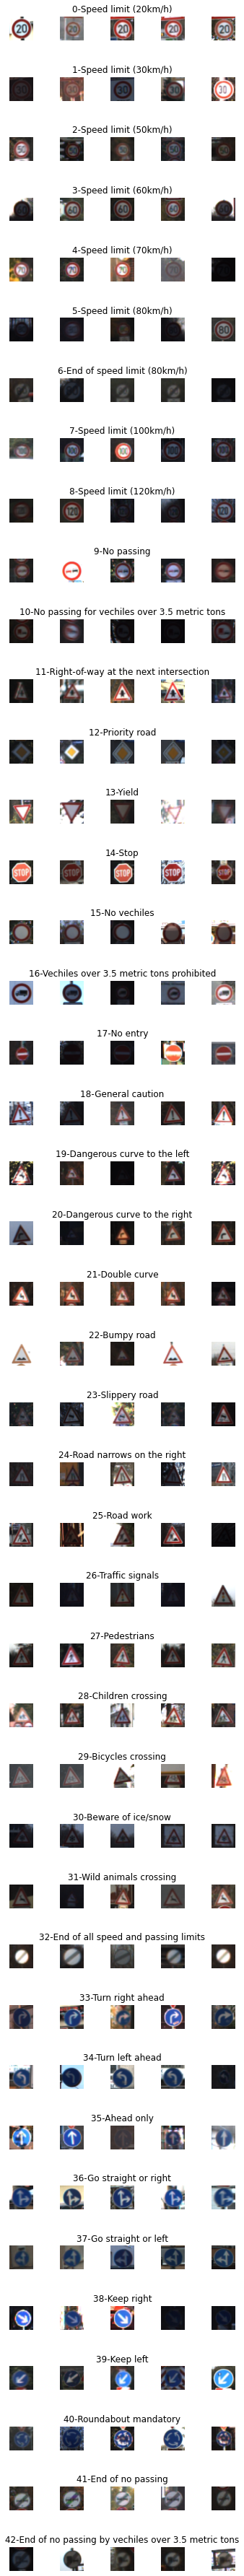

In [ ]:
data = pd.read_csv("german-traffic-signs/signnames.csv")
#plot and analyse data (visualisation)
num_of_samples = []
cols= 5
num_classes = 43
fig, axs =plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
for i in range(cols):
  for j,row in data.iterrows():
    x_selected = x_train[y_train == j]
    axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected)-1)),:,:], cmap=plt.get_cmap('gray'))
    axs[j][i].axis("off")
    if i == 2:
      axs[j][i].set_title(str(j) +"-"+ row["SignName"])
      num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


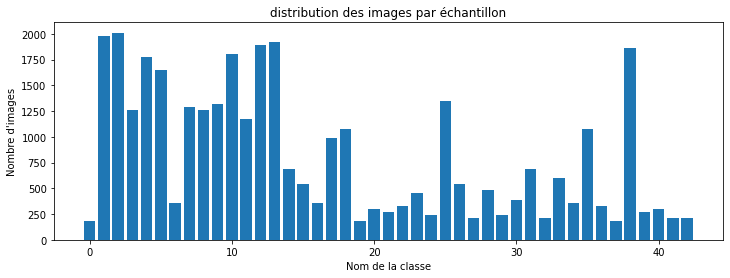

In [ ]:
print(num_of_samples)
plt.figure(figsize =(12, 4))
plt.bar(range(0,num_classes),num_of_samples)
plt.title("distribution des images par échantillon")
plt.xlabel("Nom de la classe")
plt.ylabel("Nombre d'images")
plt.show()


(32, 32, 3)
41


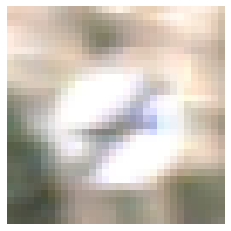

In [ ]:
import cv2 
plt.imshow(x_train[30])
plt.axis("off")
print(x_train[30].shape)
print(y_train[30])

(32, 32)


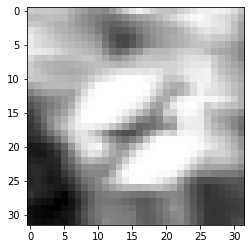

In [ ]:
def grayscale(img):
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  return gray
x = x_train[30]
img = grayscale(x)
plt.imshow(img, cmap='gray')
print(img.shape)

(-0.5, 31.5, 31.5, -0.5)

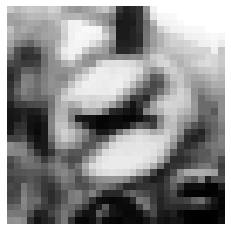

In [ ]:
def equalize(img):
  img= cv2.equalizeHist(img)
  return img

x = x_train[100]
gray= grayscale(x)
img = equalize(gray)
plt.imshow(img, cmap='gray')
plt.axis("off")


In [ ]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img
 
x_train = np.array(list(map(preprocessing, x_train)))
x_valid = np.array(list(map(preprocessing, x_valid)))
x_test = np.array(list(map(preprocessing, x_test)))

(34799, 32, 32)


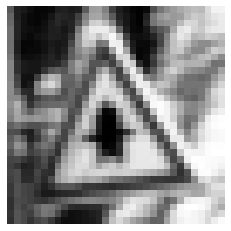

In [ ]:
plt.imshow(x_train[random.randint(0,len(x_train) - 1)], cmap='gray')
plt.axis("off")
print(x_train.shape)

In [ ]:
x_train= x_train.reshape(34799, 32, 32, 1)
x_test= x_test.reshape(12630, 32, 32, 1)
x_valid= x_valid.reshape(4410, 32, 32, 1)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagener= ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)
datagener.fit(x_train)

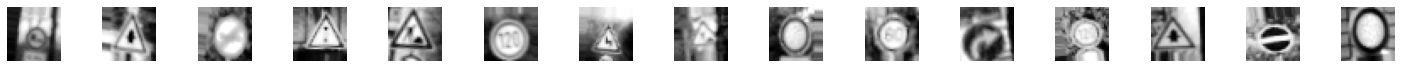

In [ ]:
batches= datagener.flow(x_train,y_train,batch_size=20)
x_batch, y_batch = next(batches)
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
for i in range(15):
  axs[i].imshow(x_batch[i].reshape(32, 32),cmap='gray')
  axs[i].axis("off")


In [ ]:
print(x_train.shape)
print(x_test.shape)
print(x_valid.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [ ]:
y_train= to_categorical(y_train, 43)
y_test= to_categorical(y_test, 43)
y_valid= to_categorical(y_valid, 43)

In [ ]:
def our_model():
  model = Sequential()
  model.add(Conv2D(60,(5,5), input_shape=(32,32,1), activation='relu'))
  model.add(Conv2D(60,(5,5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(30,(3,3), activation='relu'))
  model.add(Conv2D(30,(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes,activation ='softmax'))
  #compile model
  model.compile(Adam(lr= 0.001), loss = 'categorical_crossentropy', metrics =['accuracy'])
  return model

In [ ]:
model = our_model()
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 4, 4, 30)         

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit(x_train, y_train, epochs =10, validation_data=(x_valid,y_valid), batch_size=400,verbose= 1 , shuffle=1)

Epoch 1/10
87/87 [==============================] - 4s 37ms/step - loss: 3.1382 - accuracy: 0.1754 - val_loss: 0.6963 - val_accuracy: 0.8070
Epoch 2/10
87/87 [==============================] - 2s 26ms/step - loss: 0.8094 - accuracy: 0.7557 - val_loss: 0.2531 - val_accuracy: 0.9281
Epoch 3/10
87/87 [==============================] - 2s 27ms/step - loss: 0.4372 - accuracy: 0.8674 - val_loss: 0.1918 - val_accuracy: 0.9404
Epoch 4/10
87/87 [==============================] - 2s 27ms/step - loss: 0.3065 - accuracy: 0.9048 - val_loss: 0.1428 - val_accuracy: 0.9578
Epoch 5/10
87/87 [==============================] - 2s 27ms/step - loss: 0.2255 - accuracy: 0.9311 - val_loss: 0.1223 - val_accuracy: 0.9617
Epoch 6/10
87/87 [==============================] - 2s 27ms/step - loss: 0.1967 - accuracy: 0.9391 - val_loss: 0.1020 - val_accuracy: 0.9726
Epoch 7/10
87/87 [==============================] - 2s 27ms/step - loss: 0.1554 - accuracy: 0.9508 - val_loss: 0.0857 - val_accuracy: 0.9753
Epoch 8/10
87

Text(0.5, 0, 'epoch')

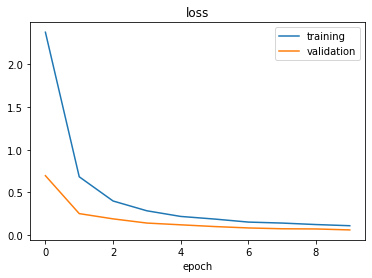

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

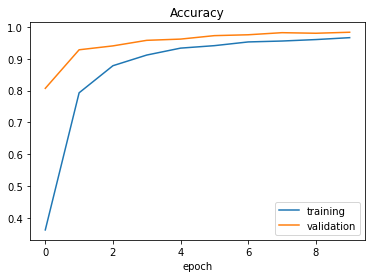

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [ ]:
score = model.evaluate(x_test,y_test,verbose=0)
print('test score:',score[0])
print('test accuracy;', score[1])

test score: 0.1443919539451599
test accuracy; 0.9608867764472961


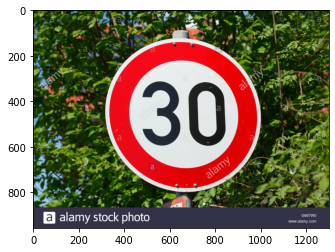

In [ ]:
import requests
from PIL import Image
url ='https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
r= requests.get(url, stream=True)
img= Image.open(r.raw)
plt.imshow(img , cmap= plt.get_cmap('gray'))

(32, 32)


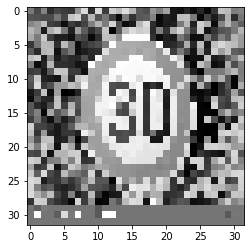

In [ ]:
img= np.asarray(img)
img = cv2.resize(img,(32,32))
img= preprocessing(img)
plt.imshow(img,cmap= plt.get_cmap('gray'))
print(img.shape)

In [ ]:
img = img.reshape(1,32,32,1)

In [ ]:
print("predicted sign is:"+str(model.predict_classes(img)))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


predicted sign is:[1]


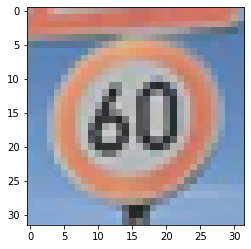

In [ ]:
from PIL import Image
url ='https://raw.githubusercontent.com/Charingchen/CarND-Traffic-Sign-Classifier/master/web_images/03.png'
r= requests.get(url, stream=True)
img= Image.open(r.raw)
plt.imshow(img , cmap= plt.get_cmap('gray'))

(32, 32)


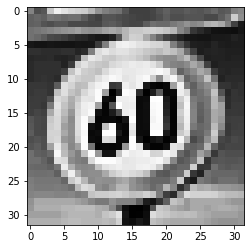

In [ ]:
img= np.asarray(img)
img = cv2.resize(img,(32,32))
img= preprocessing(img)
plt.imshow(img,cmap= plt.get_cmap('gray'))
print(img.shape)

In [ ]:
img = img.reshape(1,32,32,1)

In [ ]:
print("predicted sign is:"+str(model.predict_classes(img)))

predicted sign is:[3]


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


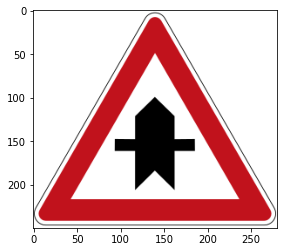

In [ ]:
from PIL import Image
url ='https://www.rhinocarhire.com/CorporateSite/media/Drive-Smart/Road-Signs/Warning-Signs/Germany-Warning-Sign-Warning-for-a-crossroad-side-roads-on-the-left-and-right.png'
r= requests.get(url, stream=True)
img= Image.open(r.raw)
plt.imshow(img , cmap= plt.get_cmap('gray'))

(32, 32)


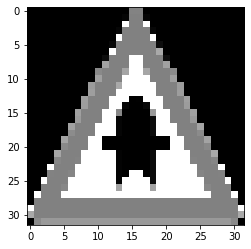

In [ ]:
img= np.asarray(img)
img = cv2.resize(img,(32,32))
img= preprocessing(img)
plt.imshow(img,cmap= plt.get_cmap('gray'))
print(img.shape)

In [ ]:
img = img.reshape(1,32,32,1)

In [ ]:
print("predicted sign is:"+str(model.predict_classes(img)))

predicted sign is:[11]


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


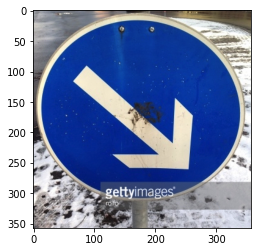

In [ ]:
 from PIL import Image
url ='https://raw.githubusercontent.com/Charingchen/CarND-Traffic-Sign-Classifier/master/web_images/38.jpeg'
r= requests.get(url, stream=True)
img= Image.open(r.raw)
plt.imshow(img , cmap= plt.get_cmap('gray'))

(32, 32)


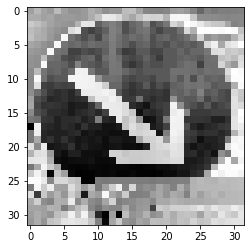

In [ ]:
img= np.asarray(img)
img = cv2.resize(img,(32,32))
img= preprocessing(img)
plt.imshow(img,cmap= plt.get_cmap('gray'))
print(img.shape)

In [ ]:
img = img.reshape(1,32,32,1)

In [ ]:
print("predicted sign is:"+str(model.predict_classes(img)))

predicted sign is:[38]


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


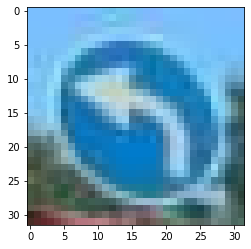

In [ ]:
from PIL import Image
url ='https://raw.githubusercontent.com/Charingchen/CarND-Traffic-Sign-Classifier/master/web_images/34.png'
r= requests.get(url, stream=True)
img= Image.open(r.raw)
plt.imshow(img , cmap= plt.get_cmap('gray'))

(32, 32)


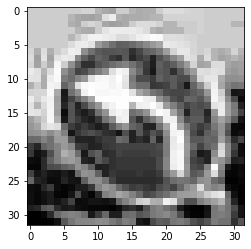

In [ ]:
img= np.asarray(img)
img = cv2.resize(img,(32,32))
img= preprocessing(img)
plt.imshow(img,cmap= plt.get_cmap('gray'))
print(img.shape)

In [ ]:
img = img.reshape(1,32,32,1)

In [ ]:
print("predicted sign is:"+str(model.predict_classes(img)))

predicted sign is:[34]


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
